## What is Polymorphism?

Broadly, polymorphism is the ability to write code that looks similar, but operates on different types. In other words, a single interface serves entities of different types. 

In most classic dynamically typed languages, of which python is one, almost all code is polymorphic. The types of values are restricted only by explicit runtime checks or errors due to failed support for operations at run time. We shall see both.

Python type system is strong and dynamic:

- strong: everything has a well-defined type: `type()`, `isinstance`
- dynamic: type is not explicitly declared, changes with content

Polymorphism is often combined with inheritance, but does not need to be.

One classification of Polymorphism (look up wikipedia) divides it on one axis into adhoc, parametric, and subtype based, and on another axis into dynamic(run time) and static(compile time).

I find dynamic polymorphism easier to understand when i think about it via a table based dispatch: that there is, somewhere, atleast conceptually, a table of types, or a linkage of such tables created by inheritance, where implementations are looked up for types.

In static polymorphism found in C++ for example, the binding to the appropriate class can be done at compile time.

### Ad-hoc polymorphism

This is the notion that for a given function, a different function is called for args of different types. 

- This enables the Python Data model with the dunder methods. If you call `len(arg)` or `iter(arg)`, we delegate to `arg`'s `__len__` or `__iter__` by *looking them up in the table(class) corresponding to arg*. The net effect is that you get different behaviors for different objects. But you are not looking up a table for the operation, but rather a table for the object. You can think of this as *single dispatch*: the `len` is dispatched based on the type of the argument by looking up a table for the argument.

- We group together the notion that an object responds to such messages into a protocol, such as for example, the informal notion that something is a sequence. This is **Duck Typing**. Alex Martelli, the coiner of this word, says:

>In Python, this mostly boils down to avoiding the use of isinstance to check the object’s type (not to mention the even worse approach of checking, for example, whether type(foo) is bar—which is rightly anathema as it inhibits even the simplest forms of inheritance!).

Here is our old example from Fluent Python:

In [67]:
import collections
Card = collections.namedtuple('Card', ['rank', 'suit'])

In [68]:
class FrenchDeck():
    ranks = [str(n) for n in range(2, 11)] + list('JQKA') 
    suits = 'spades diamonds clubs hearts'.split()
    
    def __init__(self):
        self._cards = [Card(rank, suit) for suit in self.suits for rank in self.ranks]
                       
    def __len__(self):
        return len(self._cards)
                       
    def __getitem__(self, position): 
        return self._cards[position]


In [74]:
afd = FrenchDeck()
print(len(afd))
list(afd)

52


[Card(rank='2', suit='spades'),
 Card(rank='3', suit='spades'),
 Card(rank='4', suit='spades'),
 Card(rank='5', suit='spades'),
 Card(rank='6', suit='spades'),
 Card(rank='7', suit='spades'),
 Card(rank='8', suit='spades'),
 Card(rank='9', suit='spades'),
 Card(rank='10', suit='spades'),
 Card(rank='J', suit='spades'),
 Card(rank='Q', suit='spades'),
 Card(rank='K', suit='spades'),
 Card(rank='A', suit='spades'),
 Card(rank='2', suit='diamonds'),
 Card(rank='3', suit='diamonds'),
 Card(rank='4', suit='diamonds'),
 Card(rank='5', suit='diamonds'),
 Card(rank='6', suit='diamonds'),
 Card(rank='7', suit='diamonds'),
 Card(rank='8', suit='diamonds'),
 Card(rank='9', suit='diamonds'),
 Card(rank='10', suit='diamonds'),
 Card(rank='J', suit='diamonds'),
 Card(rank='Q', suit='diamonds'),
 Card(rank='K', suit='diamonds'),
 Card(rank='A', suit='diamonds'),
 Card(rank='2', suit='clubs'),
 Card(rank='3', suit='clubs'),
 Card(rank='4', suit='clubs'),
 Card(rank='5', suit='clubs'),
 Card(rank='6', 

In [80]:
afd.__dict__, afd.__class__.__dict__

({'_cards': [Card(rank='2', suit='spades'),
   Card(rank='3', suit='spades'),
   Card(rank='4', suit='spades'),
   Card(rank='5', suit='spades'),
   Card(rank='6', suit='spades'),
   Card(rank='7', suit='spades'),
   Card(rank='8', suit='spades'),
   Card(rank='9', suit='spades'),
   Card(rank='10', suit='spades'),
   Card(rank='J', suit='spades'),
   Card(rank='Q', suit='spades'),
   Card(rank='K', suit='spades'),
   Card(rank='A', suit='spades'),
   Card(rank='2', suit='diamonds'),
   Card(rank='3', suit='diamonds'),
   Card(rank='4', suit='diamonds'),
   Card(rank='5', suit='diamonds'),
   Card(rank='6', suit='diamonds'),
   Card(rank='7', suit='diamonds'),
   Card(rank='8', suit='diamonds'),
   Card(rank='9', suit='diamonds'),
   Card(rank='10', suit='diamonds'),
   Card(rank='J', suit='diamonds'),
   Card(rank='Q', suit='diamonds'),
   Card(rank='K', suit='diamonds'),
   Card(rank='A', suit='diamonds'),
   Card(rank='2', suit='clubs'),
   Card(rank='3', suit='clubs'),
   Card(rank

- But, you can also dispatch a function based on its argument, with no lookup in that argument's table, but rather in a *table that is associated with the function*. This is also *single dispatch*, but from a different table. There is no built in support in Python for this, but you can write it on your own by associating a dictionary with multiple types. The functools module makes this easy for you by defining a @singledispatch decorator which maintains just such a dictionary (and takes care of inheritance based lookups for us...more on that in a bit).

Here is an example taken from Fluent Python

In [32]:
from functools import singledispatch
import collections
import numbers
import html

@singledispatch
def htmlize(obj):
    content = html.escape(repr(obj)) 
    return '<pre>{}</pre>'.format(content)

@htmlize.register(str) 
def _(text):
    content = html.escape(text).replace('\n', '<br>\n') 
    return '<p>{0}</p>'.format(content)

@htmlize.register(numbers.Integral) 
def _(n):
    return '<pre>{0} (0x{0:x})</pre>'.format(n)

@htmlize.register(tuple) 
@htmlize.register(collections.abc.Iterable) 
def _(seq):
    inner = '</li>\n<li>'.join(htmlize(item) for item in seq) 
    return '<ul>\n<li>' + inner + '</li>\n</ul>'

In [33]:
from IPython.display import HTML
HTML(htmlize([1,2,3,4]))

In some languages such as Julia, dispatch on the types of multiple arguments (multiple-dispatch) is also allowed; and indeed is key to the language specializing fast algorithms for specific numerical types. This too can be done in Python, but looks fairly un-natural.

### Parametric Polymorphism

We wont go into great detail here, but the basic idea is to write functions (or types) that are **generic** "over" other types. This means, for example, a stack that can take either an int or a float or an animal. Notice that this is generally true in a dynamic language such as python where objects are allocated on the heap and its the references or labels or ids that are pushed onto the stack. (This also makes Python slower). In C++ this can be done using templates at compile time to optimize the allocation of space, for example.

The key question to ask here is..does the Stack affect the behavior of an instance of type `T`, a real/integer/animal. If not, you want to use some sort of generic programming. In Python you dont even think about it...

### Subtype Polymorphism

This refers to the polymorphism that we encounter in situations where our language provides subclassing.

In a language such as C++, this referes to the notion that a dog and a cat can make sounds through an animal pointer. In python there is no using a dog as an animal, though isinstance will be true for both, so we might as well use duck-typing. So subtype polymorphism is then just ad-hoc polymorphism plus a =an sugmented lookup in the inheritance hierarchy.

We've actually encountered this in both our examples of ad-hoc polymorphism, where in the `@singledispatch` example, a simple dictionary lookup was augmented by an inheritance hierarchy lookup, and in our dunder methods, where the non-existence of a dunder method in a class would trigger a search in the inheritance hierarchy.

Indeed, this is the spot where polymorphism of the single-dispatch type on the argument table interacts with inheritance.

What's this table we talk about? We hinted at it earlier when we did:

In [82]:
afd.__class__.__dict__

mappingproxy({'__doc__': None, 'ranks': ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A'], '__dict__': <attribute '__dict__' of 'FrenchDeck' objects>, '__len__': <function FrenchDeck.__len__ at 0x1073dcc80>, '__weakref__': <attribute '__weakref__' of 'FrenchDeck' objects>, '__getitem__': <function FrenchDeck.__getitem__ at 0x1073dc048>, '__module__': '__main__', 'suits': ['spades', 'diamonds', 'clubs', 'hearts'], '__init__': <function FrenchDeck.__init__ at 0x1073dcd08>})

But What if we dont find a method here? Either this is a runtime error, or we search in the "parent" classes of this class. We can see all such attributes by using `dir`:

In [83]:
dir(afd)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cards',
 'ranks',
 'suits']

And thus notice that this works because it gets sent up:

In [84]:
hash(afd)

-9223372036578742433

You can see whats upward of the French Deck

In [88]:
FrenchDeck.mro()

[__main__.FrenchDeck, object]

Its Object, and when something like `__hash__` is not found in `FrenchDeck` its sent up to `object`.

Thus, Subtype Polymorphism works by expanding the search from the current classes table to an augmented table formed by going up the inheritance hierarchy.

### ABC's

Last time we introduced ABCs. The basic idea was to use them as a vehicle to document interfaces. We saw that:

- we could use the @abstractmethod without any implementation but with some documentation to communicate a protocol. These are the equivalent of pure virtual methods in C++.
- we could not instantiate an ABC
- an implementation could be registered, or a subclass-hook defined in an ABC which indicated that a protocol was satisfied. 

But dissapointingly, we found no checking that our implementation implemented our interface.

#### Sleuthing an ABC

Lets fix that. Back to our cards example from Fluent Python. 

In [94]:
issubclass(FrenchDeck, collections.abc.Sequence)

False

Erm, but that does not work. Clearly, unlike `Sized`, there is not a subclass-hook defined there. We can go see the source code for the Sequence ABC at https://github.com/python/cpython/blob/master/Lib/_collections_abc.py#L797 .

I reproduce it here:

```python
class Sequence(Sized, Iterable, Container):

    """All the operations on a read-only sequence.
    Concrete subclasses must override __new__ or __init__,
    __getitem__, and __len__.
    """

    __slots__ = ()

    @abstractmethod
    def __getitem__(self, index):
        raise IndexError

    def __iter__(self):
        i = 0
        try:
            while True:
                v = self[i]
                yield v
                i += 1
        except IndexError:
            return

    def __contains__(self, value):
        for v in self:
            if v == value:
                return True
        return False

    def __reversed__(self):
        for i in reversed(range(len(self))):
            yield self[i]

    def index(self, value, start=0, stop=None):
        '''S.index(value, [start, [stop]]) -> integer -- return first index of value.
           Raises ValueError if the value is not present.
        '''
        if start is not None and start < 0:
            start = max(len(self) + start, 0)
        if stop is not None and stop < 0:
            stop += len(self)

        i = start
        while stop is None or i < stop:
            try:
                if self[i] == value:
                    return i
            except IndexError:
                break
            i += 1
        raise ValueError

    def count(self, value):
        'S.count(value) -> integer -- return number of occurrences of value'
        return sum(1 for v in self if v == value)
```

There are some salient points:

- This seems to indicate that only `__getitem__` must be defined. But notice that we have `class Sequence(Sized, Iterable, Container)`. This is multiple Inheritance, where the other ABCs are being used to **Mixin** protocols that we want `Sequence` to support. So lets go digging:

In [97]:
abms=set()
abms = abms.union(collections.abc.Sequence.__abstractmethods__)
print(collections.abc.Sequence.mro())
for parent in collections.abc.Sequence.mro()[1:-1]:
    print(parent.__name__, parent.mro())
    abms=abms.union(parent.__abstractmethods__)
abms

[<class 'collections.abc.Sequence'>, <class 'collections.abc.Sized'>, <class 'collections.abc.Iterable'>, <class 'collections.abc.Container'>, <class 'object'>]
Sized [<class 'collections.abc.Sized'>, <class 'object'>]
Iterable [<class 'collections.abc.Iterable'>, <class 'object'>]
Container [<class 'collections.abc.Container'>, <class 'object'>]


{'__contains__', '__getitem__', '__iter__', '__len__'}

#### Registration

Ok, so that explains the comments above (contains can be done by having `__getitem__`. We can explicitly register to make sure all is good

In [98]:
collections.abc.Sequence.register(FrenchDeck)
deck = FrenchDeck()
issubclass(FrenchDeck, collections.abc.Sequence)

True

- But even with registration, nothing is inherited: see the mro

In [99]:
FrenchDeck.mro()

[__main__.FrenchDeck, object]

Such a class then is called a **virtual subclass**, and as we saw last time, it is not checked for ABC conformance.

#### subclassing

There is something about the ABC above which you might have found interesting.

- Despite being an ABC, it had some method implementations. These are the analogs of C++'s impure virtual functions.

This suggests that it might be worth inheriting from the ABC instead

In [100]:
class FrenchDeckTake2(collections.abc.Sequence):
    ranks = [str(n) for n in range(2, 11)] + list('JQKA') 
    suits = 'spades diamonds clubs hearts'.split()
    
    def __init__(self):
        self._cards = [Card(rank, suit) for suit in self.suits for rank in self.ranks]
                       
    def __len__(self):
        return len(self._cards)
                       
#     def __getitem__(self, position): 
#         return self._cards[position]



I purposely comment `__getitem__` out. See what happens:

In [101]:
deck = FrenchDeckTake2()

TypeError: Can't instantiate abstract class FrenchDeckTake2 with abstract methods __getitem__

We saw an error like this before where we couldnt instantiate an ABC. But now we see runtime checks: if my "implementation" does not fully implement my "interface", I am in trouble. This is the equivalent of: a concrete subclass of an ABC in C++ must implement the pure virtuals.

In [104]:
class FrenchDeckTake3(collections.abc.Sequence):
    ranks = [str(n) for n in range(2, 11)] + list('JQKA') 
    suits = 'spades diamonds clubs hearts'.split()
    
    def __init__(self):
        self._cards = [Card(rank, suit) for suit in self.suits for rank in self.ranks]
                       
    def __len__(self):
        return len(self._cards)
                       
    def __getitem__(self, position): 
        return self._cards[position]


deck = FrenchDeckTake3()

No problems now, and I seem to have picked up some methods to boot (the analogs of the impure virtuals or just plain methods). Notice that these must be defined in terms of the existing abstract and concrete methods and we will be good...

In [105]:
FrenchDeckTake3.mro()

[__main__.FrenchDeckTake3,
 collections.abc.Sequence,
 collections.abc.Sized,
 collections.abc.Iterable,
 collections.abc.Container,
 object]

In [107]:
deck.index(Card(rank='7', suit='spades'))

5

As the coder of a concrete subclass, you can override methods inherited from ABCs with more efficient implementations. For example, __contains__ works by doing a linear search, but if you were using a sorted list or binary search tree, you could do a binary search using `bisect`.

So implement a "virtual subclass" after registering if you dont want to use such methods...the ABC's wont be in the `mro()` and you might be implementing a completely "pure" ABC. To get runtime checks and utilize methods that might have been defined in the ABC, subclass.

#### Goosetyping

So why do these ABC's in the first place. Last time we saw one reason: API documentation.  But there is a second reason, analogous to duck-typing, 
Alex Martelli, calls using ABC's goosetyping, where there are explicit `isinstance` checks against an ABC. We'll see how this goose typing can come useful in operator-overloading below.

Alex, again:

>What goose typing means is: `isinstance(obj, cls)` is now just fine... as long as cls is an abstract base class—in other words, cls’s metaclass is abc.ABCMeta.

>So, here’s my valediction: whenever you’re implementing a class embodying any of the concepts represented in the ABCs in numbers, collections.abc, or other framework you may be using, be sure (if needed) to subclass it from, or register it into, the corre‐ sponding ABC. At the start of your programs using some library or framework defining classes which have omitted to do that, perform the registrations yourself; then, when you must check for (most typically) an argument being, e.g, “a sequence,” check whether: `isinstance(the_arg, collections.abc.Sequence)`

Indeed, when we use `@singledispatch`, we should only be testing against ABC's. So, whenever we use adhoc polymorphism, we'll use goose typing against ABC's and no more.

Fluent:

>...it’s usually OK to perform an insinstance check against an ABC if you must enforce an API contract: “Dude, you have to implement this if you want to call me,” as technical reviewer Lennart Regebro put it. That’s particularly useful in sys‐ tems that have a plug-in architecture. Outside of frameworks, duck typing is often sim‐ pler and more flexible than type checks.

Where else doesgoose-typing come useful?


#### Common ABCs

Diagram from Fluent:
![](abcuml.png)

Also, the `numbers` module defines the “numerical tower”:

`Number < Complex < Real < Rational < Integral`

All of this lays us squarely on the topic of inheritance.

### Inheritance 

Python supports multiple inheritance, The `mro()` method tells us where an instance looks to find methods and properties.

In [108]:
isinstance(deck, FrenchDeckTake3), isinstance(deck, collections.abc.Sequence)

(True, True)

The key notion here is that an instance of a subtype is also an instance of type and can be treated as such, as we can see above. This means that our method lookup table just expanded in a very controlled fashion.

Subtype polymorphism now works by expanding the search from the current class to other classes in the MRO. The polymorphism is the notion that two sibling classes may have he same method. The subtype or inheritance part is that these both might have been looked up elsewhere in the MRO.

Here are some useful tips:

- do not subclass built in types: there be demons

- make sure that inheritance only does **is-a**. Anything else and you have polluted your child classes.

- Distinguish Interface Inheritance from Implementation Inheritance

Inheritance for code reuse is an implementation detail. Often it can be replaced by composition and delegation. Indeed, last time, the environment "had-a" linked list, and was not supposed to inherit from it. But there are cases where its useful, as in non-abstract methods in an ABC which provide default implementations we can use or replace.

- Favor Object Composition **has-a** Over Class Inheritance.

as described above...

- Make Interfaces Explicit with ABCs

If a class is designed to define an interface/API, use a ABC

- Use Mixins for Code Reuse or protocol mixing

- Don’t Subclass from More Than One Concrete Class

### OperatorOverloading

The Python object model has dunder types such as `__len__`. But it also defines one-argument dunders such as `__add__`, which take an "object-to-add" as an argument. 

Lets first take the implicit first argument `self`, which is also there in dunders like `__len__`. As we mentioned earlier, by defining the same method on multiple classes, the correct one is picked up by seeing the class's lookup table, in a form of ad-hoc polymorphism augmented by inheritance. 

Then there is a possible second argument, and we might want to dispatch based on different types of this second argument..here we can use explicit single dispatch through a "operator" specific lookup table, or even more simply throush if/elif checks against ABCs...the goose typing we taked about earlier. In each of these cases our lookup is now implicitly method based.

So operator overloading in a dynamic language such as python is just ad-hoc polymorphism augmented by inheritance.

Fluent:
>Operator overloading allows user-defined objects to interoperate with infix operators such as + and * or unary operators like - and ~. More generally, function invocation ((), `__call__`), attribute access (., `__getattr__`), and item access/slicing ([], `__getitem__`) are also operators in Python....

>Python strikes a good balance between flexibility, usability, and safety by imposing some limitations:
• We cannot overload operators for the built-in types.
• We cannot create new operators, only overload existing ones.
• A few operators can’t be overloaded: is, and, or, not (but the bitwise &, |, ~, can).

Gosling, quoted in Fluent, explaining why java does not have operator overloading:
>Then there’s a community of about 10 percent that have actually used operator over‐ loading appropriately and who really care about it, and for whom it’s actually really important; this is almost exclusively people who do numerical work, where the notation is very important to appealing to people’s intuition, because they come into it with an intuition about what the + means, and the ability to say “a + b” where a and b are complex numbers or matrices or something really does make sense.

Here is an example. We have added unary - and +

In [137]:
#example from Fluent
from array import array 
import reprlib
import math
import numbers
import functools
import operator
import itertools

class Vector:
    typecode = 'd'
    
    def __init__(self, components):
        self._components = array(self.typecode, components)
        
    def __iter__(self):
        return iter(self._components)
    
    def __repr__(self):
        components = reprlib.repr(self._components) 
        components = components[components.find('['):-1] 
        return 'Vector({})'.format(components)
    
    def __eq__(self, other):
        return (len(self) == len(other) and
            all(a == b for a, b in zip(self, other)))
    
    def __abs__(self):
        return math.sqrt(sum(x * x for x in self))
    
    def __bool__(self): 
        return bool(abs(self))
    
    def __len__(self):
        return len(self._components)
    
    def __getitem__(self, index): 
        cls = type(self)
        
        if isinstance(index, slice):
            return cls(self._components[index])
        elif isinstance(index, numbers.Integral): 
            return self._components[index]
        else:
            msg = '{.__name__} indices must be integers' 
            raise TypeError(msg.format(cls))
            
    def __neg__(self):
        return Vector(-x for x in self) 
    
    def __pos__(self):
        return Vector(self)

In [138]:
v1 = Vector([3, 4])
v2 = Vector([3.1, 4.2])
v3 = Vector([3, 4, 5])
v4 = Vector([3, 4])
v1==v2, v1==v4, list(v1), v1

(False, True, [3.0, 4.0], Vector([3.0, 4.0]))

In [139]:
+v1, -v1

(Vector([3.0, 4.0]), Vector([-3.0, -4.0]))

Also, dunders are great!

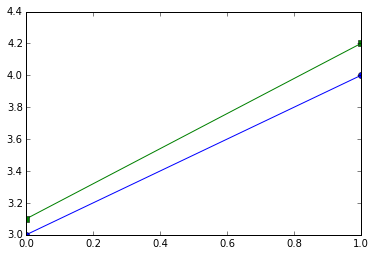

In [140]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(v1,'o-')
plt.plot(v2,'s-');

Notice we return new Vectors. 

**Unary or Infix operations should never change arguments**

What happens on addition?

In [141]:
v1+ v2

TypeError: unsupported operand type(s) for +: 'Vector' and 'Vector'

In [142]:
v1 + [1,2]

TypeError: unsupported operand type(s) for +: 'Vector' and 'list'

Ok, so lets add that!

In [127]:
#example from Fluent
from array import array 
import reprlib
import math
import numbers
import functools
import operator
import itertools

class Vector:
    typecode = 'd'
    
    def __init__(self, components):
        self._components = array(self.typecode, components)
        
    def __iter__(self):
        return iter(self._components)
    
    def __repr__(self):
        components = reprlib.repr(self._components) 
        components = components[components.find('['):-1] 
        return 'Vector({})'.format(components)
    
    def __eq__(self, other):
        return (len(self) == len(other) and
            all(a == b for a, b in zip(self, other)))
    
    def __abs__(self):
        return math.sqrt(sum(x * x for x in self))
    
    def __bool__(self): 
        return bool(abs(self))
    
    def __len__(self):
        return len(self._components)
    
    def __getitem__(self, index): 
        cls = type(self)
        
        if isinstance(index, slice):
            return cls(self._components[index])
        elif isinstance(index, numbers.Integral): 
            return self._components[index]
        else:
            msg = '{.__name__} indices must be integers' 
            raise TypeError(msg.format(cls))
            
    def __neg__(self):
        return Vector(-x for x in self) 
    
    def __pos__(self):
        return Vector(self)
    
    def _check_length(function):
        def _check_length_helper(self , rhs):
            if not len(self)==len(rhs):
                raise ValueError(str(self)+' and '+str(rhs)+' must have the same length')
            return function(self,rhs)
        return _check_length_helper
    
    @_check_length
    def __add__(self, rhs):
        pairs = zip(self, rhs)
        return Vector(a + b for a, b in pairs)

In [128]:
v1 = Vector([3, 4])
v2 = Vector([3.1, 4.2])
v3 = Vector([3, 4, 5])
v4 = Vector([3, 4])
v1 + v2

Vector([6.1, 8.2])

In [129]:
v1 + 5

TypeError: object of type 'int' has no len()

In [130]:
v1 + [1,2]

Vector([4.0, 6.0])

???? What happened here???????

`other` implements the iterator protocol and everything just works.

But:

#### How overloading is done?

The process for infix ops is this (from Fluent):


1. If a has `__add__`, call a.`__add__`(b) and return result unless it’s NotImplemented. 
2. If a doesn’t have `__add__`, or calling it returns NotImplemented, check if b has `__radd__`, then call `b.__radd__(a)` and return result unless it’s NotImplemented. 
3. If b doesn’t have `__radd__`, or calling it returns NotImplemented, raise TypeError with an unsupported operand types message.

In [136]:
[1,2] + v1

TypeError: can only concatenate list (not "Vector") to list

#### ..the "right" methods

`__radd__` method is called the “right” version of `__add__`. 
To make the mixed-types addition  work, we need to also implement the `__radd__` which Python calls if and only if:
- the left operand does not implement `__add__ ` : here it does but because its a list it thinks we want to concatenate
- or if the left-hand operand does but returns `NotImplemented` 

From Fluent

>if an operator special method cannot return a valid result because of type incom‐ patibility, it should return NotImplemented and not raise TypeError. By returning NotImplemented, you leave the door open for the implementer of the other operand type to perform the operation when Python tries the reversed method call.

We'll use duck-typing here and just catch exceptions, returning `NotImplemented`, thus enabling the reverse lookup. If the reverse (in step 2. above also retuens `NotImplemented`, a `TypeError` is thrown. Best for 


In [156]:
#example from Fluent
from array import array 
import reprlib
import math
import numbers
import functools
import operator
import itertools

class Vector:
    typecode = 'd'
    
    def __init__(self, components):
        self._components = array(self.typecode, components)
        
    def __iter__(self):
        return iter(self._components)
    
    def __repr__(self):
        components = reprlib.repr(self._components) 
        components = components[components.find('['):-1] 
        return 'Vector({})'.format(components)
    
    def __eq__(self, other):
        return (len(self) == len(other) and
            all(a == b for a, b in zip(self, other)))
    
    def __abs__(self):
        return math.sqrt(sum(x * x for x in self))
    
    def __bool__(self): 
        return bool(abs(self))
    
    def __len__(self):
        return len(self._components)
    
    def __getitem__(self, index): 
        cls = type(self)
        
        if isinstance(index, slice):
            return cls(self._components[index])
        elif isinstance(index, numbers.Integral): 
            return self._components[index]
        else:
            msg = '{.__name__} indices must be integers' 
            raise TypeError(msg.format(cls))
            
    def __neg__(self):
        return Vector(-x for x in self) 
    
    def __pos__(self):
        return Vector(self)
    
    def _check_length_helper(self , rhs):
        if not len(self)==len(rhs):
            raise ValueError(str(self)+' and '+str(rhs)+' must have the same length')
    
    def __add__(self, rhs):
        try:
            self._check_length_helper(rhs)
            pairs = zip(self, rhs)
            return Vector(a + b for a, b in pairs)
        except TypeError:
            return NotImplemented
    
    def __radd__(self, other): # other + self delegates to __add__
        return self + other

In [157]:
v1 = Vector([3, 4])
v1 + [1,2]

Vector([4.0, 6.0])

In [158]:
[1,2]+v1

Vector([4.0, 6.0])

Ok, but:

In [159]:
v1+4

TypeError: unsupported operand type(s) for +: 'Vector' and 'int'

In [160]:
4 + v1

TypeError: unsupported operand type(s) for +: 'Vector' and 'int'

We should support this. What should be our semantics? I think it should add a constant to every item, like in numpy. Thiusis where goose-typing comes in with case or dispatch based dealing with other types



In [161]:
#example from Fluent
from array import array 
import reprlib
import math
import numbers
import functools
import operator
import itertools

class Vector:
    typecode = 'd'
    
    def __init__(self, components):
        self._components = array(self.typecode, components)
        
    def __iter__(self):
        return iter(self._components)
    
    def __repr__(self):
        components = reprlib.repr(self._components) 
        components = components[components.find('['):-1] 
        return 'Vector({})'.format(components)
    
    def __eq__(self, other):
        if isinstance(other, Vector):
            return (len(self) == len(other) and
                all(a == b for a, b in zip(self, other)))
        else:
            return NotImplemented
    
    def __abs__(self):
        return math.sqrt(sum(x * x for x in self))
    
    def __bool__(self): 
        return bool(abs(self))
    
    def __len__(self):
        return len(self._components)
    
    def __getitem__(self, index): 
        cls = type(self)
        
        if isinstance(index, slice):
            return cls(self._components[index])
        elif isinstance(index, numbers.Integral): 
            return self._components[index]
        else:
            msg = '{.__name__} indices must be integers' 
            raise TypeError(msg.format(cls))
            
    def __neg__(self):
        return Vector(-x for x in self) 
    
    def __pos__(self):
        return Vector(self)
    
    def _check_length_helper(self , rhs):
        if not len(self)==len(rhs):
            raise ValueError(str(self)+' and '+str(rhs)+' must have the same length')
    
    def __add__(self, rhs):
        try:
            if isinstance(rhs, numbers.Real):
                return Vector(a + rhs for a in self) 
            else: #
                self._check_length_helper(rhs)
                pairs = zip(self, rhs)
                return Vector(a + b for a, b in pairs)
        except TypeError:
            raise NotImplemented
    
    def __radd__(self, other): # other + self delegates to __add__
        return self + other

In [162]:
v1 = Vector([3, 4])
v1 + [1,2], [1,2] + v1

(Vector([4.0, 6.0]), Vector([4.0, 6.0]))

In [163]:
v1 + 3, 3 + v1

(Vector([6.0, 7.0]), Vector([6.0, 7.0]))

Out-of-place augmented addition comed for free. If you want in-place, implement `__iadd__`. Why ought you not do it here?

In [164]:
v1 += 3
v1

Vector([6.0, 7.0])

In [165]:
v1 += 3
v1

Vector([9.0, 10.0])

This covers unary, infix, comparison-infix.

### No leakage and ease of use

- Our TS class shouldnt be any harder to use than `array`
- The array.array internal implementation should not leak out, even in errors...(we talked about this last time in the interface-implementation separation as well...



In [55]:
import numpy as np
1 < np.array([1,2])
import pandas as pd
p=pd.Series([1,2,3])
print(type(p))
p2=np.exp(p)
p2, type(p2)
np.exp([1,2,3])

<class 'pandas.core.series.Series'>


array([  2.71828183,   7.3890561 ,  20.08553692])